# Моделирование роста монокристаллического твердого раствора $Al_xGa_{1-x}N$ методом хлоридной эпитаксии


## Сазанович Владислав М3339

In [5]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.linalg
import sympy as sm
from tqdm import tqdm
from ggplot import *

# Для тестов
def is_close(a, b, rel_tol=1e-06, abs_tol=0.0):
    return abs(a-b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

In [6]:
row_data = pd.read_csv('q.csv', sep=';', 
                       index_col=False, 
                       names=["", "Phase", "T1", "T2", "H", "f1", "f2", "f3", "f4", "f5", "f6", "f7", 
                              "mu", "sigma", "epsil", "Comment"])
row_data.set_index('', inplace = True)
row_data

,Phase,T1,T2,H,f1,f2,f3,f4,f5,f6,f7,mu,sigma,epsil,Comment
,,,,,,,,,,,,,,,
AlCl,g,298.15,3000.00,-51032.0,318.9948,36.946260,-0.001226,1.188174,5.638541,-5.066135,5.219347,62.4345,3.580,932.00,"1,2"
AlCl2,g,298.15,3000.00,-259000.0,427.2137,56.564090,-0.002961,1.893842,12.400720,-22.654410,21.298980,97.8875,5.300,825.00,"1,2,55"
AlCl3,g,298.15,3000.00,-584100.0,511.8114,81.150420,-0.004835,2.752097,13.400780,-21.280010,16.928680,133.3405,5.130,472.00,"1,2"
GaCl,g,298.15,3000.00,-70553.0,332.2718,37.110520,-0.000746,1.160651,4.891346,-4.467591,5.506236,105.1730,3.696,348.20,1
GaCl2,g,298.15,3000.00,-241238.0,443.2976,57.745845,-0.002265,1.875554,3.661860,-9.356338,15.882450,140.6260,4.293,465.00,1
GaCl3,g,298.15,3000.00,-431573.0,526.8113,82.033550,-0.003486,2.685592,8.278878,-14.567800,12.889900,176.0800,5.034,548.24,1
NH3,g,298.15,3000.00,-45940.0,231.1183,20.522220,0.000716,0.767724,244.629600,-251.690000,146.694700,17.0310,3.000,300.00,"26,1"
H2,g,298.15,3000.00,0.0,205.5368,29.504870,0.000168,0.860656,-14.953120,78.189550,-82.789810,2.0160,2.930,34.10,"4,1"
HCl,g,298.15,3000.00,-92310.0,243.9878,23.159840,0.001820,0.614738,51.166040,-36.895020,9.174252,36.4610,2.737,167.10,1


In [7]:
# Constants
R = 8.314 # Дж/(моль*К)

# Распределение веществ по твердым, жидким и газообазным
solid = {'Al', 'AlN', 'GaN'}
liquid = {'Ga'}
gas = {'AlCl', 'AlCl2', 'AlCl3', 'GaCl', 'GaCl2', 'GaCl3', 'NH3', 'H2', 'HCl', 'N2'}

""" Коэффициенты диффузии (м2/сек) для газообразных компонент
ind - 'AlCl', 'GaN, ... 
t - температура в К
p - полное давление в системе
"""
def calcDGas(ind, t, p):
    assert (ind in gas), "This function could caclulate D only for gaseous substance"
    
    numerator = 2.628 * 10**(-2) * t**(3/2)
    
    d_ind = row_data.loc[ind]
    d_N2 = row_data.loc['N2']
    
    sigma = (d_ind.sigma + d_N2.sigma) / 2
    epsil = (d_ind.epsil * d_N2.epsil)**(1/2)
    mu = (2 * d_ind.mu * d_N2.mu) / (d_ind.mu + d_N2.mu)
    omega = 1.074 * (t / epsil)**(-0.1604)
    
    return numerator / (p * omega * mu**(1/2))


"""
Φ для расчета энергии Гиббса
ind - 'AlCl', 'GaN, ... 
t - температура в К
"""
def calcPhi(ind, t):
    data = row_data.loc[ind]
    x = t / 10**4
    
    return data.f1 + data.f2 * np.log(x) + data.f3 / x**2 + data.f4 / x + data.f5 * x + data.f6 * x**2 + data.f7 * x**3
   
    
"""
Энергия Гиббса
ind - 'AlCl', 'GaN, ... 
t - температура в К
"""
def calcG(ind, t):
    data = row_data.loc[ind]
    return data.H - calcPhi(ind, t) * t

Pa = 100000 # атмосферное давление


def calcK1(t):
    deltaG1 = 2 * calcG('Al', t) + 2 * calcG('HCl', t) - 2 * calcG('AlCl', t) - calcG('H2', t)
    return np.exp(-deltaG1 / (R * t)) / Pa


def calcK2(t):
    deltaG2 = calcG('Al', t) + 2 * calcG('HCl', t) - calcG('AlCl2', t) - calcG('H2', t)
    return np.exp(-deltaG2 / (R * t))


def calcK3(t):
    deltaG3 = calcG('Al', t) - 2 * calcG('AlCl3', t) - 3 * calcG('H2', t) + 6 * calcG('HCl', t)
    return np.exp(-deltaG3 / (R * t)) * Pa


def calcK4(t):
    deltaG4 = calcG('Ga', t) + 2 * calcG('HCl', t) - 2 * calcG('GaCl', t) - calcG('H2', t)
    return np.exp(-deltaG4 / (R * t)) / Pa


def calcK5(t):
    deltaG5 = calcG('GaCl2', t) + calcG('H2', t) - 2 * calcG('HCl', t) - calcG('Ga', t)
    return np.exp(deltaG5 / (R * t))


def calcK6(t):
    deltaG6 = 2 * calcG('GaCl3', t) + 3 * calcG('H2', t) - 6 * calcG('HCl', t) - 2 * calcG('Ga', t)
    return np.exp(deltaG6 / (R * t)) * Pa


def calcK9(t):
    deltaG9 = calcG('AlCl3', t) + calcG('NH3', t) - calcG('AlN', t) - 3 * calcG('HCl', t)
    return np.exp(-deltaG9 / (R * t)) / Pa


def calcK10(t):
    deltaG10 = calcG('GaCl', t) + calcG('NH3', t) - calcG('HCl', t) - calcG('H2', t) - calcG('GaN', t)
    return np.exp(-deltaG10 / (R * t))


print(calcK1(100))
print(calcK2(100))
print(calcK3(100))
print(calcK4(100))
print(calcK5(100))
print(calcK6(100))
print(calcK9(100))
print(calcK10(100))

2.27702386893e+30
6.3155395805e-40
4.80309849033e-309
492253.458522
5.19845126314e-32
1.99523068921e-150
86699219.3922
5.44646362935e-44


# Первое задание

In [8]:
"""
Парциальные давления компонент вне диффузионного пограничного слоя (Па)
PS Даны в условии поэтому дефайним только для этого задания
ind - 'AlCl', 'GaN, ... 
"""
def first_calcPg(ind):
    if ind == 'AlCl' or ind == 'AlCl2' or ind == 'AlCl3' or ind == 'H2':
        return 0
    if ind == 'HCl':
        return 10000
    if ind == 'N2':
        return 90000
    raise Exception('Unexpected substance: ' + ind)

    
def first_make_system(pg_HCl=10000.0, p=100000, T=(350.0 + 273.0)):
    p_AlCl, p_AlCl2, p_AlCl3, p_HCl, p_H2 = first_variables = sm.symbols('p_AlCl, p_AlCl2, p_AlCl3, p_HCl, p_H2')
    k1 = calcK1(T)
    k2 = calcK2(T)
    k3 = calcK3(T)
    d_HCl = calcDGas('HCl', T, p)
    d_H2 = calcDGas('H2', T, p)
    d_AlCl = calcDGas('AlCl', T, p)
    d_AlCl2 = calcDGas('AlCl2', T, p)
    d_AlCl3 = calcDGas('AlCl3', T, p)
    equations = []
    equations.append(p_HCl ** 2 - k1 * p_AlCl ** 2 * p_H2)
    equations.append(p_HCl ** 2 - k2 * p_AlCl2 * p_H2)
    equations.append(p_HCl ** 6 - k3 * p_AlCl3 ** 2 * p_H2 ** 3)
    equations.append(d_HCl * (p_HCl - pg_HCl) + 2 * d_H2 * p_H2)
    equations.append(d_AlCl  * p_AlCl  + 
                 2 * d_AlCl2 * p_AlCl2 + 
                 3 * d_AlCl3 * p_AlCl3 + 
                     d_HCl * (p_HCl - pg_HCl))
    system = sm.Matrix(equations)
    jacobian = system.jacobian(first_variables)
    system = sm.lambdify(first_variables, system)
    jacobian = sm.lambdify(first_variables, jacobian)
    return system, jacobian, first_variables

def first_newton_solve(T, epsilon=1e-9):
    system, jacobian, first_variables = first_make_system(T=T)
    # TODO: think about gaussian std
    x = np.random.normal(0., 1., 5).tolist()
    delta = 1
    nstep = 0
    while np.linalg.norm(delta) > epsilon:
        delta = sp.linalg.lu_solve(sp.linalg.lu_factor(jacobian(*x)), -system(*x))
        x = delta.flatten() + x
        nstep += 1
    # evaluate error: residual sum of absulute values F(x)
    rsa = np.abs(system(*x.tolist())).sum()
    return x, rsa, nstep

print('One of solutions:')
system, jacobian, first_variables = first_make_system(350 + 273)
dict(zip(first_variables, first_newton_solve(350 + 273)[0]))

One of solutions:


{p_AlCl: -0.003803649257255444,
 p_AlCl2: 0.00015128466077543311,
 p_AlCl3: 4379.4257974339816,
 p_HCl: 0.00012849360183162214,
 p_H2: 1516.5792358713427}

In [9]:
# benchmark
Ts = np.linspace(350, 650, 60) + 273
nruns = 10
sigma = 0.01
p = first_calcPg('HCl') + first_calcPg('N2')
first_newton_benchmark = pd.DataFrame(columns=['T_', 'V_Al', 'G_AlCl', 'G_AlCl2', 'G_AlCl3', 
                                         'rsa', 'rsa_std', 'nstep', 'nstep_std'])
targets = ['AlCl', 'AlCl2', 'AlCl3']
for k, T in tqdm(list(enumerate(Ts))):
    sols = np.zeros((nruns, 5))
    rsa = np.zeros(nruns)
    nstep = np.zeros(nruns)
    for i in range(nruns):
        sols[i], rsa[i], nstep[i] = first_newton_solve(T)
    sol_std = sols.std(0)
    solution = sols.mean(0)
    rsa_std = rsa.std()
    rsa = rsa.mean()
    nstep_std = nstep.std()
    nstep = nstep.mean()
    # G_i
    G = {}
    Pe = dict(zip(map(str, first_variables), solution))
    for Gas in targets:
        G[Gas] = calcDGas(Gas, T, p) * (first_calcPg(Gas) - Pe['p_' + Gas]) / (R * T * sigma)
    pho = 2712.0
    mu = row_data.loc['Al'].mu
    V = (G['AlCl'] + G['AlCl2'] + G['AlCl3']) * (mu / pho) * 1e9
    first_newton_benchmark.loc[k] = {
        'T_': T,
        'V_Al': V,
        'G_AlCl': G['AlCl'],
        'G_AlCl2': G['AlCl2'],
        'G_AlCl3': G['AlCl3'],
        'rsa': rsa,
        'rsa_std': rsa_std,
        'nstep': nstep,
        'nstep_std': nstep_std
    }

100%|██████████| 60/60 [00:18<00:00,  3.21it/s]


In [10]:
first_newton_benchmark

,T_,V_Al,G_AlCl,G_AlCl2,G_AlCl3,rsa,rsa_std,nstep,nstep_std
0,623.000000,-572239.293105,3.105399e-08,-1.958718e-09,-0.057518,1.349735e-15,5.598412e-16,49.1,6.847627
1,628.084746,-575319.607089,8.056389e-15,-2.396461e-09,-0.057827,1.400534e-15,8.038182e-16,51.2,3.841875
2,633.169492,-578390.935002,4.842970e-08,-2.922309e-09,-0.058136,1.576525e-15,1.059532e-15,48.5,5.500000
3,638.254237,-581454.552802,1.910915e-14,-3.552005e-09,-0.058444,1.448352e-15,7.416780e-16,48.7,3.661967
4,643.338983,-584509.562422,2.892729e-14,-4.303745e-09,-0.058751,2.325818e-15,1.235850e-15,47.3,3.522783
5,648.423729,-587556.592146,-3.061511e-08,-5.198491e-09,-0.059057,6.039527e-16,3.776806e-16,47.2,3.893584
6,653.508475,-590595.609794,-7.528002e-08,-6.260331e-09,-0.059363,1.137796e-15,6.578891e-16,48.1,2.118962
7,658.593220,-593625.490559,4.612685e-08,-7.516874e-09,-0.059667,6.836289e-16,6.652170e-16,43.1,5.393515
8,663.677966,-596648.213378,5.634798e-08,-8.999664e-09,-0.059971,8.688314e-16,5.526820e-16,44.6,6.118823
9,668.762712,-599663.035804,6.862081e-08,-1.074467e-08,-0.060274,1.296823e-15,4.620137e-16,42.1,3.330165


In [11]:
first_newton_benchmark['invT'] = 1 / first_newton_benchmark.T_
first_newton_benchmark['V_Al_log'] = np.log(np.abs(first_newton_benchmark.V_Al))
first_newton_benchmark['G_AlCl_log'] = np.log(np.abs(first_newton_benchmark.G_AlCl))
first_newton_benchmark['G_AlCl2_log'] = np.log(np.abs(first_newton_benchmark.G_AlCl2))
first_newton_benchmark['G_AlCl3_log'] = np.log(np.abs(first_newton_benchmark.G_AlCl3))
first_newton_df = pd.melt(first_newton_benchmark[['invT', 'V_Al_log', 'G_AlCl_log', 
                                      'G_AlCl2_log', 'G_AlCl2_log', 'G_AlCl3_log']], id_vars=['invT'])

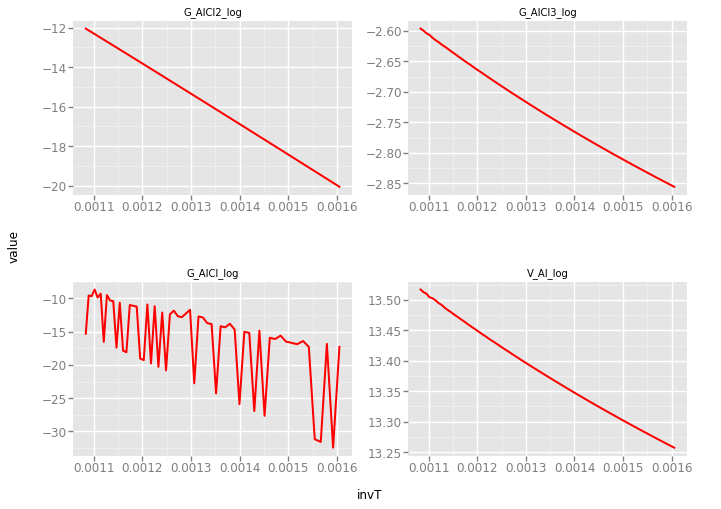

<ggplot: (-9223372036565469436)>

In [12]:
ggplot(aes(x = 'invT', y = 'value'), first_newton_df) + \
    geom_line(size=2, color='red') + \
    facet_wrap('variable', scales='free')

# Второе задание

In [13]:
def second_calcPg(ind):
    if ind == 'GaCl' or ind == 'GaCl2' or ind == 'GaCl3' or ind == 'H2':
        return 0
    if ind == 'HCl':
        return 10**4
    if ind == 'N2':
        return 9 * 10**4
    raise Exception('Unexpected substance: ' + ind)

def second_make_system(p=100000, T=(650.0 + 273.0)):
    p_GaCl, p_GaCl2, p_GaCl3, p_HCl, p_H2 = second_variables = sm.symbols('p_GaCl, p_GaCl2, p_GaCl3, p_HCl, p_H2')
    pg_HCl = 10**4
    pg_N2 = 9 * 10**4
    k4 = calcK4(T)
    k5 = calcK5(T)
    k6 = calcK6(T)
    d_HCl = calcDGas('HCl', T, p)
    d_H2 = calcDGas('H2', T, p)
    d_GaCl = calcDGas('GaCl', T, p)
    d_GaCl2 = calcDGas('GaCl2', T, p)
    d_GaCl3 = calcDGas('GaCl3', T, p)
    equations = []
    equations.append(p_HCl ** 2 - k4 * p_GaCl ** 2 * p_H2)
    equations.append(p_HCl ** 2 - k5 * p_GaCl2 * p_H2)
    equations.append(p_HCl ** 6 - k6 * p_GaCl3 ** 2 * p_H2 ** 3)
    equations.append(d_HCl * (p_HCl - pg_HCl) + 2 * d_H2 * p_H2)
    equations.append(d_GaCl  * p_GaCl  + 
                 2 * d_GaCl2 * p_GaCl2 + 
                 3 * d_GaCl3 * p_GaCl3 + 
                     d_HCl * (p_HCl - pg_HCl))
    system = sm.Matrix(equations)
    jacobian = system.jacobian(second_variables)
    system = sm.lambdify(second_variables, system)
    jacobian = sm.lambdify(second_variables, jacobian)
    return system, jacobian, second_variables


def second_newton_solve(T, epsilon=1e-9):
    system, jacobian, second_variables = second_make_system(T=T)
    # TODO: think about gaussian std
    x = np.random.normal(0., 1., 5).tolist()
    delta = 1
    nstep = 0
    while np.linalg.norm(delta) > epsilon:
        delta = sp.linalg.lu_solve(sp.linalg.lu_factor(jacobian(*x)), -system(*x))
        x = delta.flatten() + x
        nstep += 1
    # evaluate error: residual sum of absulute values F(x)
    rsa = np.abs(system(*x.tolist())).sum()
    return x, rsa, nstep


print('One of solutions:')
system, jacobian, second_variables = second_make_system(650.0 + 273)
dict(zip(second_variables, second_newton_solve(650.0 + 273)[0]))

One of solutions:


{p_GaCl: 12533.641465315402,
 p_GaCl2: 0.11749094248081585,
 p_GaCl3: 1.1409407780527707e-05,
 p_HCl: -0.26071574649660273,
 p_H2: 1516.6187949676748}

In [14]:
# benchmark
Ts = np.linspace(650, 950, 60) + 273
nruns = 10
sigma = 0.01
p = second_calcPg('HCl') + second_calcPg('N2')
second_newton_benchmark = pd.DataFrame(columns=['T_', 'V_Ga', 'G_GaCl', 'G_GaCl2', 'G_GaCl3', 
                                         'rsa', 'rsa_std', 'nstep', 'nstep_std'])
targets = ['GaCl', 'GaCl2', 'GaCl3']
for k, T in tqdm(list(enumerate(Ts))):
    sols = np.zeros((nruns, 5))
    rsa = np.zeros(nruns)
    nstep = np.zeros(nruns)
    for i in range(nruns):
        sols[i], rsa[i], nstep[i] = second_newton_solve(T)
    sol_std = sols.std(0)
    solution = sols.mean(0)
    rsa_std = rsa.std()
    rsa = rsa.mean()
    nstep_std = nstep.std()
    nstep = nstep.mean()
    # G_i
    G = {}
    Pe = dict(zip(map(str, second_variables), solution))
    for Gas in targets:
        G[Gas] = calcDGas(Gas, T, p) * (second_calcPg(Gas) - Pe['p_' + Gas]) / (R * T * sigma)
    pho = 5900.
    mu = row_data.loc['Ga'].mu
    V = (G['GaCl'] + G['GaCl2'] + G['GaCl3']) * (mu / pho) * 1e9
    second_newton_benchmark.loc[k] = {
        'T_': T,
        'V_Ga': V,
        'G_GaCl': G['GaCl'],
        'G_GaCl2': G['GaCl2'],
        'G_GaCl3': G['GaCl3'],
        'rsa': rsa,
        'rsa_std': rsa_std,
        'nstep': nstep,
        'nstep_std': nstep_std
    }

100%|██████████| 60/60 [00:19<00:00,  3.32it/s]


In [15]:
second_newton_benchmark

,T_,V_Ga,G_GaCl,G_GaCl2,G_GaCl3,rsa,rsa_std,nstep,nstep_std
0,923.000000,-2.643517e+06,-0.223694,-1.993719e-06,-7.513897e-11,3.327878e-14,5.311801e-14,35.3,3.742993
1,928.084746,-2.653141e+06,-0.224508,-1.848171e-06,-6.407355e-11,4.974938e-15,6.497075e-15,36.9,6.503076
2,933.169492,-2.662720e+06,-0.225319,-1.714554e-06,-2.737029e-11,7.489339e-14,1.390530e-13,37.2,5.653318
3,938.254237,-2.672307e+06,-0.226131,-1.591854e-06,4.682733e-11,1.601920e-14,2.699817e-14,33.3,2.570992
4,943.338983,-2.681851e+06,-0.226938,-1.479024e-06,-2.006784e-11,1.942966e-14,2.897197e-14,35.8,3.155947
5,948.423729,-2.691377e+06,-0.227744,-1.375217e-06,-3.445319e-11,9.063272e-14,1.787678e-13,35.3,2.609598
6,953.508475,-2.700886e+06,-0.228549,-1.279635e-06,-2.962322e-11,1.241789e-13,2.457216e-13,35.5,5.004998
7,958.593220,-2.710416e+06,-0.229356,-1.191590e-06,-8.860595e-16,8.963063e-14,2.117260e-13,35.6,3.352611
8,963.677966,-2.719890e+06,-0.230158,-1.110361e-06,-1.100055e-11,5.219491e-14,1.394144e-13,37.1,5.682429
9,968.762712,-2.729361e+06,-0.230959,-1.035403e-06,5.157463e-20,2.583411e-13,4.641828e-13,37.3,2.531798


In [16]:
second_newton_benchmark['invT'] = 1 / second_newton_benchmark.T_
second_newton_benchmark['V_Ga_log'] = np.log(np.abs(second_newton_benchmark.V_Ga))
second_newton_benchmark['G_GaCl_log'] = np.log(np.abs(second_newton_benchmark.G_GaCl))
second_newton_benchmark['G_GaCl2_log'] = np.log(np.abs(second_newton_benchmark.G_GaCl2))
second_newton_benchmark['G_GaCl3_log'] = np.log(np.abs(second_newton_benchmark.G_GaCl3))
second_newton_df = pd.melt(second_newton_benchmark[['invT', 'V_Ga_log', 'G_GaCl_log', 
                                      'G_GaCl2_log', 'G_GaCl2_log', 'G_GaCl3_log']], id_vars=['invT'])

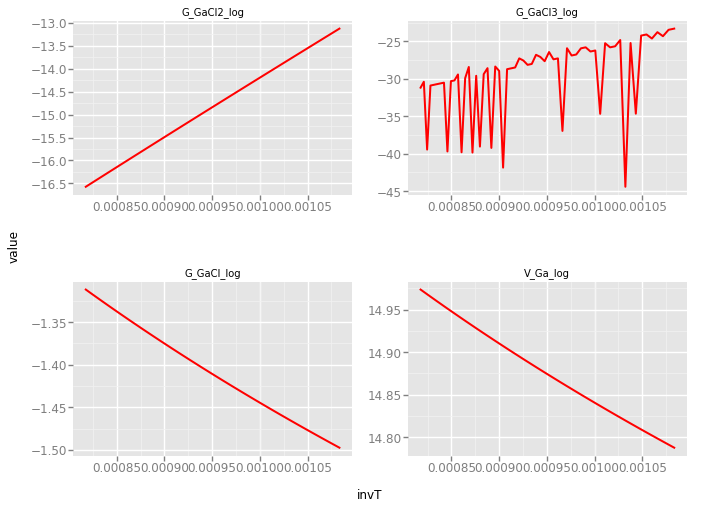

<ggplot: (-9223372036564561706)>

In [17]:
ggplot(aes(x = 'invT', y = 'value'), second_newton_df) + \
    geom_line(size=2, color='red') + \
    facet_wrap('variable', scales='free')